In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from datetime import date, timedelta
import os
import xarray as xr

In [2]:
df_lookup = pd.read_csv("../data/processed/predictors/formation.csv", parse_dates=['formation_datetime'])

In [3]:
def get_sst_by_date_offset(ts, lat, lon, days_earlier):

	form_date = ts.date() # Convert from Timestamp to datetime.date
	lookup_date = form_date - timedelta(days = days_earlier)
	# target_prev_sunday = target_date - timedelta(days = (target_date.weekday() + 1) % 7)
	# target_first_of_month = date(target_date.year, target_date.month, 1)

	if lookup_date.year >= 1982:
		path = "OISSTv2hi/sst.day.mean.{year}.nc".format(year = lookup_date.year)
		var_name = 'sst'
		convert = True
	else:
		path = "20CRV3/sst.1851-1981.nc"
		var_name = 'skt'
		convert = False

	with xr.open_dataset(os.path.join("../data", "raw", "sst", path)) as ds:
		sst = ds[var_name].sel(
			lat = lat,
			lon = lon,
			time = lookup_date,
			method = 'nearest'
		).item()

	if convert:
		sst += 273.15 # convert from °C to K

	return sst

In [4]:
lead_times = [0, 3, 7, 14]
for lead in lead_times:
	df_lookup[f'sst_minus_{lead}_days'] = df_lookup.apply(axis='columns', func = lambda row: get_sst_by_date_offset(row['formation_datetime'], row['formation_lat'], row['formation_lon'], lead))

In [5]:
results = df_lookup.drop(axis='columns', labels=['formation_lat','formation_lon','formation_datetime'])
results.head()

,code,sst_minus_0_days,sst_minus_3_days,sst_minus_7_days,sst_minus_14_days
0,AL011851,300.822784,300.668274,300.664642,300.507751
1,AL011852,301.461853,301.511688,301.491577,301.323486
2,AL011853,300.384827,300.278046,300.207855,300.172699
3,AL011854,301.572540,301.760437,301.408539,300.834229
4,AL011855,300.633118,300.985199,300.907898,301.544464


In [7]:
missing = df_lookup[df_lookup.sst_minus_0_days.isna()]
missing

,code,formation_datetime,formation_lat,formation_lon,sst_minus_0_days,sst_minus_3_days,sst_minus_7_days,sst_minus_14_days
170,AL012022,2022-06-02 18:00:00,21.3,272.5,NaN,NaN,NaN,NaN
307,AL021988,1988-08-08 00:00:00,30.4,269.7,NaN,NaN,NaN,NaN
495,AL032003,2003-06-28 06:00:00,19.5,271.0,NaN,NaN,NaN,NaN
684,AL042024,2024-08-02 12:00:00,20.4,284.2,NaN,NaN,NaN,NaN
810,AL051986,1986-08-13 12:00:00,30.1,276.0,NaN,NaN,NaN,NaN
1438,AL102010,2010-09-04 18:00:00,17.5,264.4,NaN,NaN,NaN,NaN
1758,AL152001,2001-10-29 18:00:00,13.3,276.4,NaN,NaN,NaN,NaN
1803,AL162000,2000-10-04 12:00:00,29.0,278.6,NaN,NaN,NaN,NaN


In [9]:
with xr.open_dataset(os.path.join("../data", "raw", "sst", "OISSTv2hi/sst.day.mean.2022.nc")) as ds:
	print(ds.variables)
	sst = ds['sst'].sel(
		lat = 21.3,
		lon = 272.5,
		time = date(2022, 6, 2),
		method = 'nearest'
	).item()
	print(sst)

Frozen({'sst': <xarray.Variable (time: 365, lat: 720, lon: 1440)> Size: 2GB
[378432000 values with dtype=float32]
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  36.16], 'time': <xarray.IndexVariable 'time' (time: 365)> Size: 3kB
array(['2022-01-01T00:00:00.000000000', '2022-01-02T00:00:00.000000000',
       '2022-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      shape=(365,), dtype='datetime64[ns]')
Attributes:
    long_name:     Time
    delta_t:       0000-00-01 00:00:00
    avg_period:    0000-00-01 00:00:00
    axis:          T
    actual_range:  [81084. 81448.], 'lat': <xarray.IndexV

In [18]:
results.to_csv("../data/processed/predictors/sst.csv", index=False)

Could not load basemap (optional). Skipping.


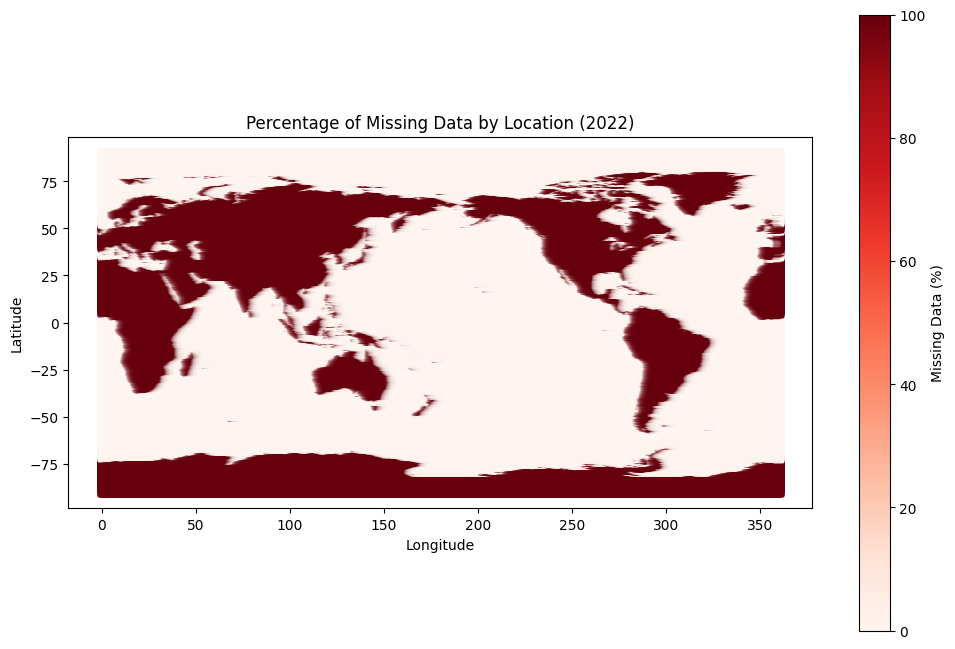

In [ ]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

ds = xr.open_dataset('../data/raw/sst/OISSTv2hi/sst.day.mean.2022.nc')
data = ds['sst']

missing_pct = data.isnull().mean(dim='time') * 100

df = missing_pct.to_dataframe(name='missing_pct').reset_index()

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat)
)


fig, ax = plt.subplots(figsize=(12, 8))

plot = gdf.plot(
    column='missing_pct',
    ax=ax,
    legend=True,
    legend_kwds={'label': "Missing Data (%)"},
    cmap='Reds', 
    marker='s', 
    markersize=45,
    alpha=0.8     
)

plt.title(f"Percentage of Missing Data by Location ({ds.time.dt.year[0].item()})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save the map
plt.savefig("missing_data_map.png")
plt.show()

In [12]:
url = "https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip"
coastlines = gpd.read_file(url)

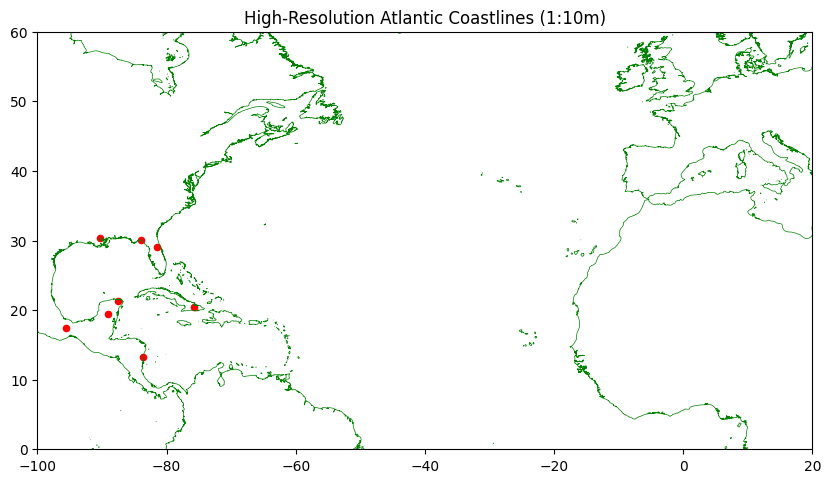

In [ ]:
gdf = gpd.GeoDataFrame(
    missing,
    geometry=gpd.points_from_xy(missing.formation_lon.apply(lambda x: x - 360 if x > 180 else x), missing.formation_lat),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))
coastlines.plot(ax=ax, linewidth=0.5, color='green')

gdf.plot(
	ax=ax,
	# column='record_identifier',
	markersize=20,
	marker='o',
	color='r',
	label='Observations'
)

# ax.set_xlim(-85, -80)
# ax.set_ylim(20,27)


ax.set_xlim(-100, 20) 
ax.set_ylim(0, 60)  

plt.title("High-Resolution Atlantic Coastlines (1:10m)")
plt.show()

In [16]:
hurdat = pd.read_csv('../data/raw/hurdat2_cleaned.csv', parse_dates=['observation_datetime','formation_datetime'])

In [20]:
hurdat[hurdat.code == 'AL021988']

,code,name,record_identifier,status,max_sus_wind_kt,min_pressure_mb,r_34kt_ne,r_34kt_se,r_34kt_sw,r_34kt_nw,...,r_50kt_nw,r_64kt_ne,r_64kt_se,r_64kt_sw,r_64kt_nw,r_max_sus,observation_datetime,formation_datetime,lat,lon
36916,AL021988,BERYL,NaN,TD,25.0,1010.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-08 00:00:00,1988-08-08,30.4,269.7
36917,AL021988,BERYL,NaN,TD,30.0,1009.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-08 06:00:00,1988-08-08,29.7,270.3
36918,AL021988,BERYL,NaN,TS,35.0,1007.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-08 12:00:00,1988-08-08,29.7,270.6
36919,AL021988,BERYL,NaN,TS,40.0,1005.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-08 18:00:00,1988-08-08,29.4,270.8
36920,AL021988,BERYL,NaN,TS,45.0,1002.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-09 00:00:00,1988-08-08,29.3,270.9
36921,AL021988,BERYL,NaN,TS,45.0,1001.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-09 06:00:00,1988-08-08,29.6,270.5
36922,AL021988,BERYL,NaN,TS,45.0,1002.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-09 12:00:00,1988-08-08,30.1,269.6
36923,AL021988,BERYL,NaN,TS,40.0,1005.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-09 18:00:00,1988-08-08,30.1,269.1
36924,AL021988,BERYL,NaN,TD,30.0,1006.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-10 00:00:00,1988-08-08,30.3,268.4
36925,AL021988,BERYL,NaN,TD,30.0,1007.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1988-08-10 06:00:00,1988-08-08,30.7,267.8


In [18]:
missing

,code,formation_datetime,formation_lat,formation_lon,sst_minus_0_days,sst_minus_3_days,sst_minus_7_days,sst_minus_14_days
170,AL012022,2022-06-02 18:00:00,21.3,272.5,NaN,NaN,NaN,NaN
307,AL021988,1988-08-08 00:00:00,30.4,269.7,NaN,NaN,NaN,NaN
495,AL032003,2003-06-28 06:00:00,19.5,271.0,NaN,NaN,NaN,NaN
684,AL042024,2024-08-02 12:00:00,20.4,284.2,NaN,NaN,NaN,NaN
810,AL051986,1986-08-13 12:00:00,30.1,276.0,NaN,NaN,NaN,NaN
1438,AL102010,2010-09-04 18:00:00,17.5,264.4,NaN,NaN,NaN,NaN
1758,AL152001,2001-10-29 18:00:00,13.3,276.4,NaN,NaN,NaN,NaN
1803,AL162000,2000-10-04 12:00:00,29.0,278.6,NaN,NaN,NaN,NaN


In [19]:
export = missing[['code']]
export.reset_index(drop=True, inplace=True)
export.to_csv("missing.csv")